In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import os
import joblib
from collections import OrderedDict

import torch

from sklearn import preprocessing as pre
from sklearn.neighbors import KernelDensity

import datetime

from tqdm.notebook import tqdm
from util.data import get_country_df
from models import enc_dec

sns.set()
plt.rcParams['figure.figsize'] = (10, 5)
NUM_WORKERS = os.cpu_count()

np.random.seed(1234)

## Analyze Distribution of Auto-encoder loss
In the previous notebook, we defined and trained a neural network to encode and decode event data from stable countries. In this notebook we will analyze the loss distribution of the model in order to choose an anomaly threshold.

### Aggregate Stable Country Data
First, we will retrieve and concatenate a selection of traditionally stable countries. These countries don't have a perfect history of peace, but most activity should be low level civil unrest such as peaceful protests. We will this data as a baseline for determining anomalous activity.

In [2]:
stable_countries = ['United States', 'United Kingdom', 'Spain', 'France']

stable_df = pd.DataFrame()
for c in stable_countries:
    temp_df = get_country_df(c, 'data/icews/')
    stable_df = pd.concat([stable_df, temp_df])
    
stable_df.Country.value_counts()

loading data/icews/icews_united_states_raw.parquet... done.
loading data/icews/icews_united_kingdom_raw.parquet... done.
loading data/icews/icews_spain_raw.parquet... done.
loading data/icews/icews_france_raw.parquet... done.


United States     250772
United Kingdom    126277
France             90539
Spain              23640
Name: Country, dtype: int64

In [3]:
drop = ['Source Country', 'Target Country',
        'Country', 'Latitude', 'Longitude',
        'Event ID', 'Source Name', 
        'Source Sectors','Target Name', 
        'Target Sectors', 'Event Date',
        'Story ID','Sentence Number', 
        'Publisher', 'District',
        'Province', 'City']

stable_df = stable_df.drop(drop, axis=1)

Next, we want to one-hot encode 'Event Text', which tells what kind of event occured. Because there may be events in the larger dataset that do not occur in this "Stabel countries" dataset, we will pull the categorical features from the total data before encoding:

In [4]:
# Get comprehensive list of all 'Event Text' categories.
all_data = pd.read_parquet('data/icews/icews_all_raw.parquet')['Event Text'].astype('string')

In [5]:
# Use comprehensive list to fit one-hot-encoder for tranformation
ohe = pre.OneHotEncoder(sparse=False)
ohe.fit(all_data.to_numpy().reshape(-1, 1))
joblib.dump(ohe, 'data/models/ohe.joblib')

# Get one-hot encoded Event Text category
oh_data = ohe.transform(stable_df['Event Text'].to_numpy().reshape(-1, 1))

In [6]:
# Concatenate original data with one-hot data and drop 'Event Text'
oh_data = pd.DataFrame(data=oh_data, columns=ohe.categories_[0], index=stable_df.index)
stable_df = pd.concat([stable_df, oh_data], axis=1)
stable_df.drop(['Event Text'], axis=1, inplace=True)

### Defining Network Architecture
Now that the we have aggregated several stable countries' data, we will load a trained auto-encoder architecture that knows how to compress event data and reconstruct it from a compressed form. It's loss should increase when presented with unstable event data, which will cue us to an anomaly occuring.

In [7]:
# Define auto encoder architecture
hidden_layers = (100, 75, 50, 75, 100)
input_size = stable_df.shape[1]
output_size = input_size

# Create and load pre-trained weights into model:
model = fc.FCNetwork(input_size, hidden_layers, output_size)
model.load_state_dict(torch.load('data/models/ae1.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Creating Probability Density Estimate of Network Loss
Next, we will create estimate a probability density function of the network loss when applied to stable country input data. This probability density function will be used to choose a loss threshold above which model input is considered anomalous. 

In [8]:
with torch.no_grad():
    x = torch.tensor(stable_df.to_numpy())
    x_hat = model(x)
    mae = (x - x_hat).abs().mean(dim=1).numpy()

In [9]:
# Generate Kernel Density Estimate using Silverman heuristics
bw = 1.06 * mae.std() * mae.size ** (-1 / 5.)
kde = KernelDensity(bandwidth=bw).fit(mae.reshape(-1, 1))
joblib.dump(kde, 'data/models/kde.joblib')

['data/models/kde.joblib']

In [10]:
# Generate evenly spaced samples for plotting density function estimate
values = np.arange(0.01, 0.1, .0005).reshape(-1, 1)
p = kde.score_samples(values)
p = np.exp(p)

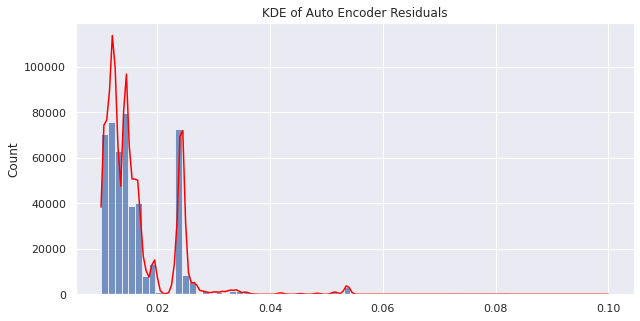

In [11]:
# Verify density function estimate
sns.lineplot(x=values.squeeze(), y=p.squeeze() *.7e3, color='red')
sns.histplot(mae, bins=60)
plt.gca().set(title='KDE of Auto Encoder Residuals');

Based on the above histogram, it appears as though the auto-encoder loss largely falls below 0.04, so this will be a good threshold for our anomaly detection in the next notebook. 